In [3]:
%matplotlib inline
import numpy as np
import pylab as pl
from glob import glob
import os
from astropy.io import fits
from astropy import visualization
from astropy.visualization import simple_norm
pl.rcParams['image.origin'] = 'lower'
pl.style.use('dark_background')

In [4]:
biases = glob('darkOnly_40ms*.FIT')
darks_40ms_filelist = glob('darkOnly_40ms*.FIT')
darks_100ms_filelist = glob('darkOnly_40ms*.FIT')
clear_flat = glob('twilight_Clear*.FIT')
B_flat = glob('twilight_B*.FIT')
V_flat = glob('twilight_V*.FIT')
I_flat = glob('twilight_I*.FIT')

# Biases and Readnoise

In [5]:
bias_timestream = [fits.getdata(x)*fits.getheader(x)['EGAIN'] for x in biases]
mean_bias = np.mean(bias_timestream, axis=0)
stddev_bias = np.std(bias_timestream, axis=0)
readnoise = np.mean(stddev_bias)
del bias_timestream

In [6]:
mean_bias_noise = readnoise/np.sqrt(len(biases))
mean_bias_noise



4.9151353755340494

# Flats

In [7]:
#Clear, B , V , I
flat = [clear_flat, B_flat, V_flat, I_flat]
flat_timestream = []
mean_flat = []
bias_subtracted_flat = []
normed_flat = []

for i in range(4):
    flat_timestream.append([fits.getdata(x)*fits.getheader(x)['EGAIN'] for x in flat[i]])
    mean_flat.append(np.mean(flat_timestream[i], axis=0))
    bias_subtracted_flat.append(mean_flat[i] - mean_bias)
    normed_flat.append(bias_subtracted_flat[i]/bias_subtracted_flat[i].mean())
    
del flat_timestream



# Flat Uncertainty

In [8]:
gain = fits.getheader('twilight_Clear001.FIT')['EGAIN']
flat_poisson_uncertainty = []
flat_singleframe_uncertainty = []
flat_total_uncertainty = []
normalized_mean_flat = []

for i in range(4):
    flat_poisson_uncertainty.append((bias_subtracted_flat[i])**0.5)
    flat_singleframe_uncertainty.append((flat_poisson_uncertainty[i]**2 + readnoise**2)**0.5)
    flat_total_uncertainty.append(((flat_singleframe_uncertainty[i]/np.sqrt(len(flat[i])))**2 + mean_bias_noise**2)**0.5)
    mean_of_flat = np.mean(bias_subtracted_flat[i])
    normalized_mean_flat.append(bias_subtracted_flat[i] / mean_of_flat)


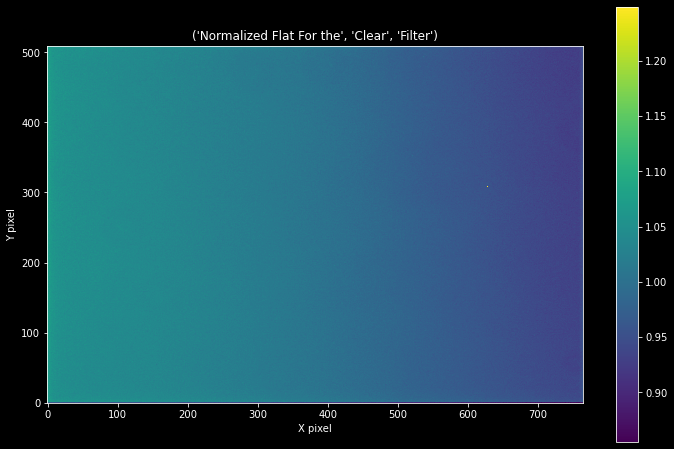

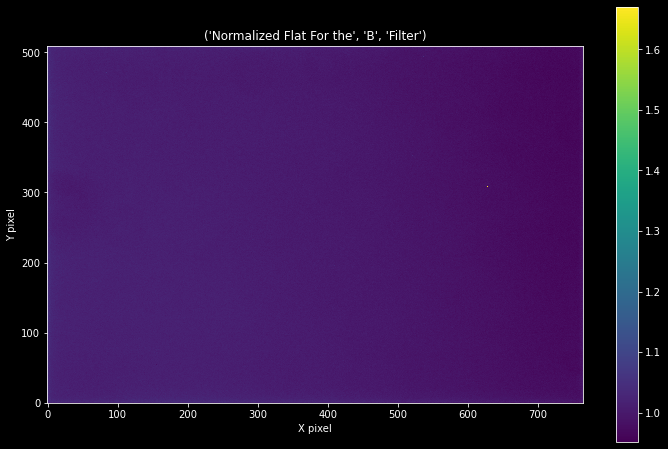

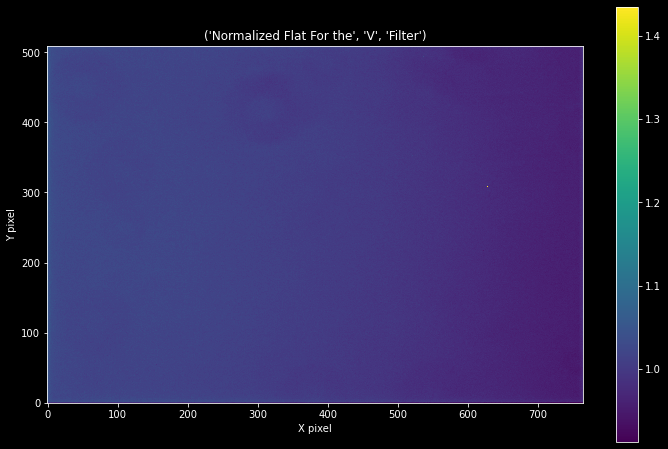

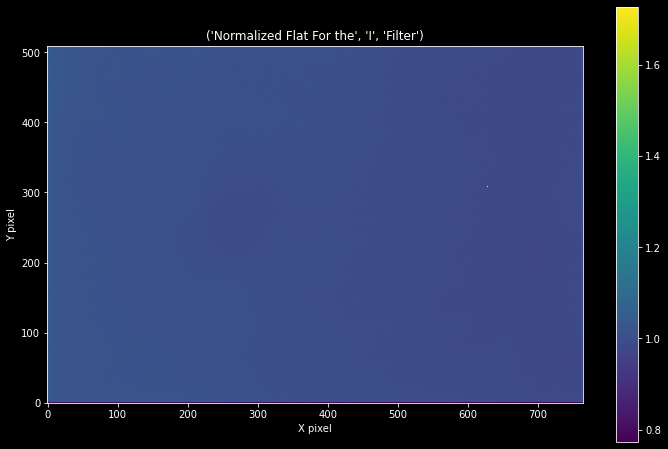

In [9]:
names = ["Clear", "B", "V", "I"]
for i in range(4):
    temp = 'Normalized Flat For the', names[i], 'Filter'
    pl.figure(figsize=(12,8))
    _=pl.imshow(normalized_mean_flat[i], origin='lower', interpolation='none')
    _=pl.colorbar()
    _=pl.title(temp)
    _=pl.xlabel("X pixel")
    _=pl.ylabel("Y pixel")

# Normalized Flat Uncertainty

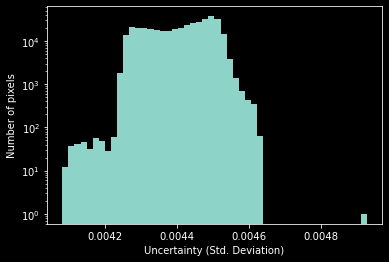

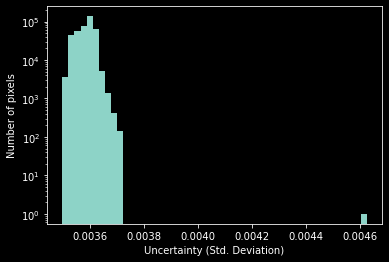

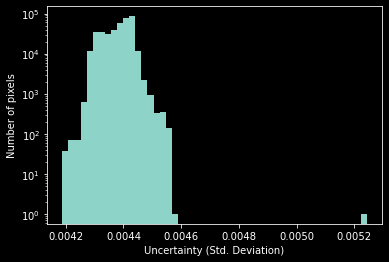

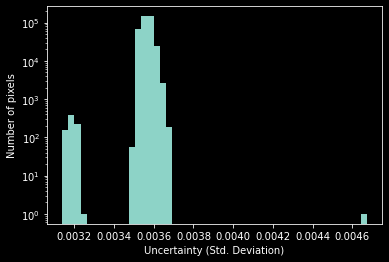

In [10]:
normalized_flat_uncertainty = []
for i in range(4):
    pl.figure()
    normalized_flat_uncertainty.append(flat_total_uncertainty[i] / mean_of_flat)
    pl.xlabel("Uncertainty (Std. Deviation)")
    pl.ylabel("Number of pixels")
    _=pl.hist(normalized_flat_uncertainty[i].ravel(), bins=50, log=True)


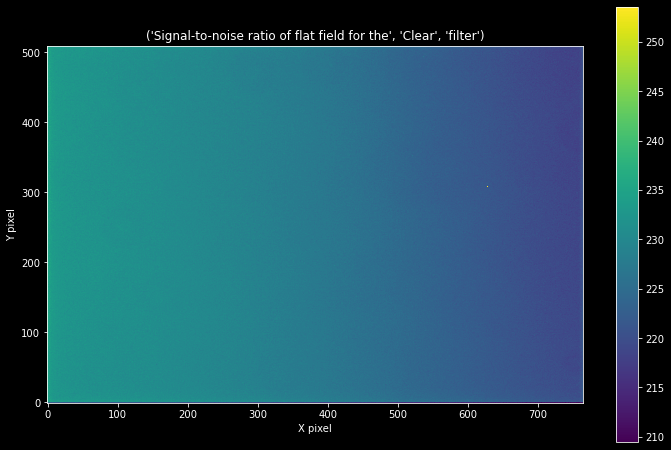

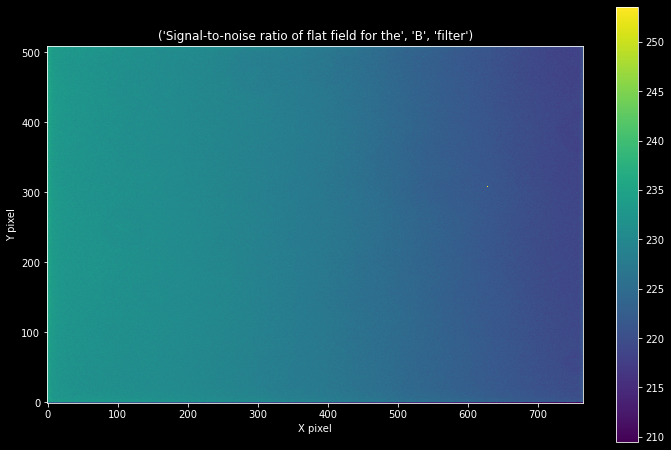

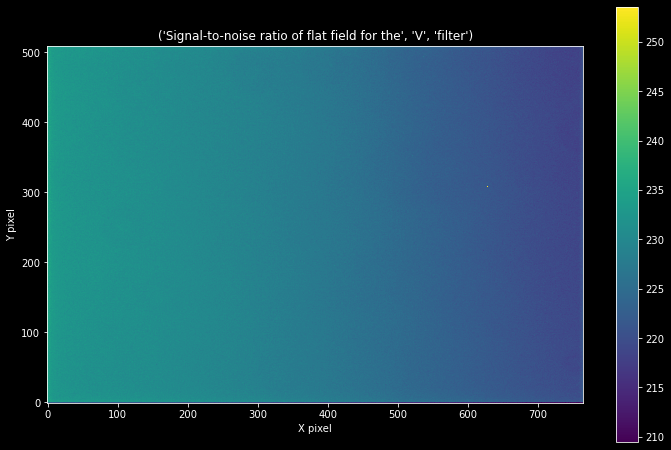

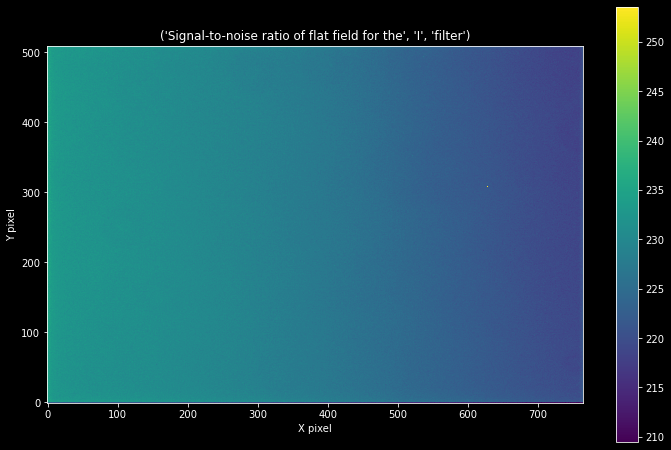

In [11]:
for i in range(4):
    temp = "Signal-to-noise ratio of flat field for the", names[i], "filter"
    pl.figure(figsize=(12,8))
    pl.imshow(normalized_mean_flat[0]/normalized_flat_uncertainty[0], origin='lower', interpolation='none')
    pl.title(temp)
    pl.colorbar()
    _=pl.xlabel("X pixel")
    _=pl.ylabel("Y pixel")

In [12]:
darks_40ms = [fits.getdata(x)*fits.getheader(x)['EGAIN'] for x in darks_40ms_filelist]
average_40ms_dark = np.mean(darks_40ms, axis=0)
stddev_40ms_dark = np.std(darks_40ms, axis=0)
del darks_40ms

darks_100ms = [fits.getdata(x)*fits.getheader(x)['EGAIN'] for x in darks_100ms_filelist]
average_100ms_dark = np.mean(darks_100ms, axis=0)
stddev_100ms_dark = np.std(darks_100ms, axis=0)
del darks_100ms

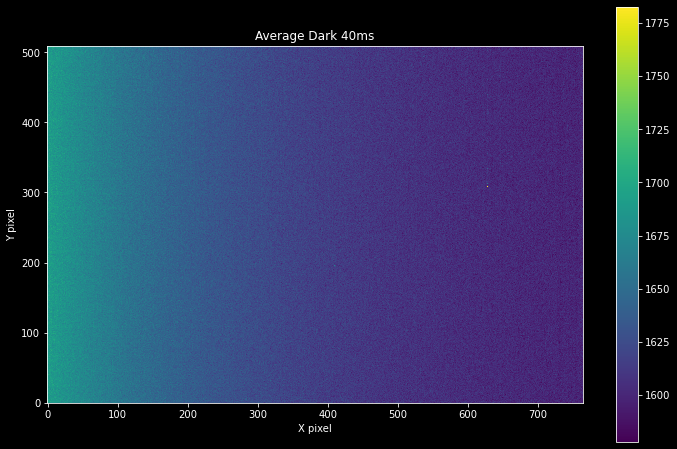

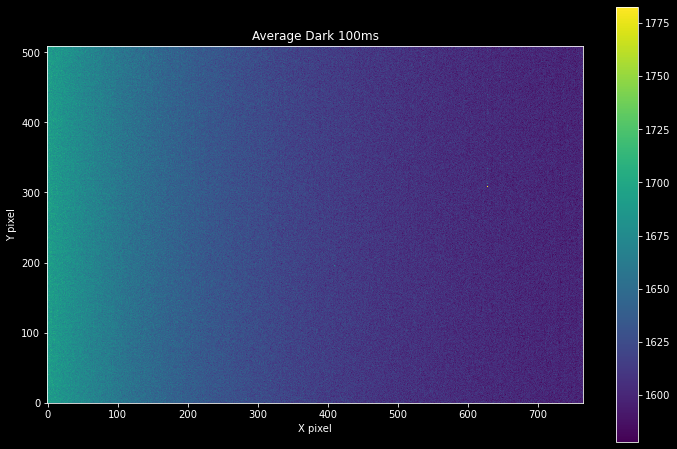

In [13]:
pl.figure(figsize=(12,8))
pl.imshow(average_40ms_dark, origin='lower', interpolation='none', vmax=1150*gain)
pl.colorbar()
_=pl.title("Average Dark 40ms")
_=pl.xlabel("X pixel")
_=pl.ylabel("Y pixel")

uncertainty_on_40ms_mean_dark = stddev_40ms_dark / np.sqrt(len(darks_40ms_filelist))

pl.figure(figsize=(12,8))
pl.imshow(average_100ms_dark, origin='lower', interpolation='none', vmax=1150*gain)
pl.colorbar()
_=pl.title("Average Dark 100ms")
_=pl.xlabel("X pixel")
_=pl.ylabel("Y pixel")

uncertainty_on_100ms_mean_dark = stddev_100ms_dark / np.sqrt(len(darks_100ms_filelist))

# Science Images

## Saturn

Saturn Alignment:

In [14]:
SaturnFilelist = ['Saturn_B_40ms002.FIT', 'Saturn_B_40ms003.FIT',
                 'Saturn_V_40ms001.FIT', 'Saturn_V_40ms002.FIT', 'Saturn_V_40ms003.FIT',
                 'Saturn_I_40ms001.FIT', 'Saturn_I_40ms002.FIT', 'Saturn_I_40ms003.FIT']

SaturnCenters_X = [409.3, 409.0, 409.0, 407.0, 410.0, 407.5, 409.0, 408.0]
SaturnCenters_Y = [217.7, 218.0, 213.6, 212.3, 214.0, 213.4, 214.3, 213.0] 

#Making 'Saturn_B_40ms001.FIT' the reference frame.
refx, refy = 408.6, 217.7 
Saturn_shift = [fits.getdata('Saturn_B_40ms001.FIT')*fits.getheader('Saturn_B_40ms001.FIT')[ 'EGAIN']]

for i in range(len(SaturnFilelist)):
    im = fits.getdata(SaturnFilelist[i])*fits.getheader(SaturnFilelist[i])[ 'EGAIN']
    dx = refx - SaturnCenters_X[i]
    dy = refy - SaturnCenters_Y[i]
    dx, dy = round(dx), round(dy)    
    im_shift = np.roll(im, dy, axis=0)
    im_shift = np.roll(im_shift, dx, axis=1)
    Saturn_shift.append(im_shift)
    #Saving the shifted images
    header = fits.getheader(SaturnFilelist[i])
    fh = fits.PrimaryHDU(data=im_shift, header=header) 
    fh.writeto('shifted_' + SaturnFilelist[i], overwrite=True)

header = fits.getheader('Saturn_B_40ms001.FIT')
fh = fits.PrimaryHDU(data=Saturn_shift[0], header=header) 
fh.writeto('shifted_' + 'Saturn_B_40ms001.FIT', overwrite=True)

Image Processing:

<ipython-input-15-7697d3812dcc>:14: RuntimeWarning: divide by zero encountered in true_divide
  saturn_darksub_flattened_uncertainty.append(((saturn_darksub_uncertainty[i]**2 / saturn_darksub[i]**2 +normalized_flat_uncertainty[0]**2 / normalized_mean_flat[num]**2) * saturn_darksub_flattened[i]**2)**0.5)
<ipython-input-15-7697d3812dcc>:14: RuntimeWarning: invalid value encountered in multiply
  saturn_darksub_flattened_uncertainty.append(((saturn_darksub_uncertainty[i]**2 / saturn_darksub[i]**2 +normalized_flat_uncertainty[0]**2 / normalized_mean_flat[num]**2) * saturn_darksub_flattened[i]**2)**0.5)
<ipython-input-15-7697d3812dcc>:12: RuntimeWarning: invalid value encountered in sqrt
  saturn_darksub_uncertainty.append((saturn_darksub[i] + readnoise**2 + uncertainty_on_40ms_mean_dark**2)**0.5)


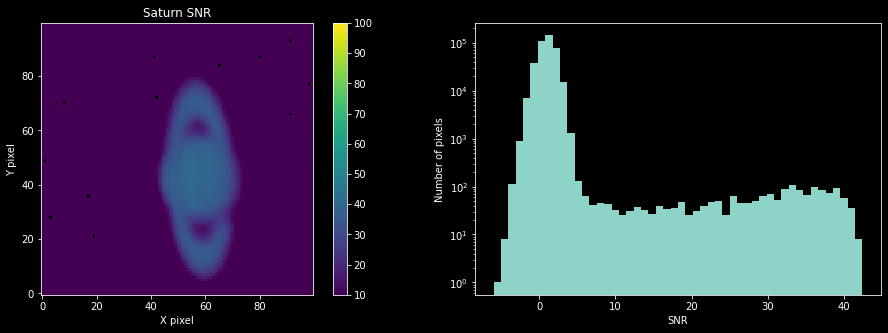

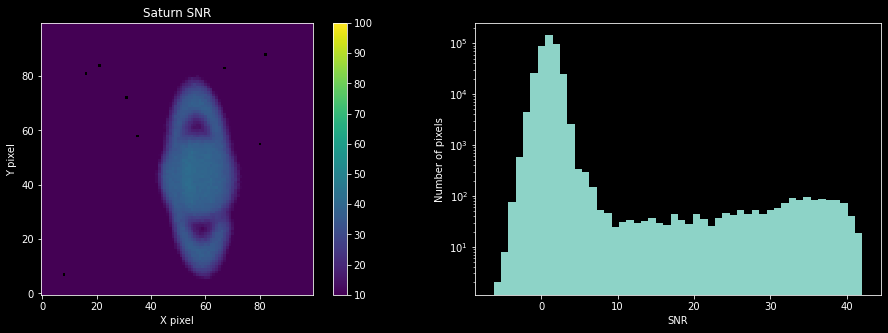

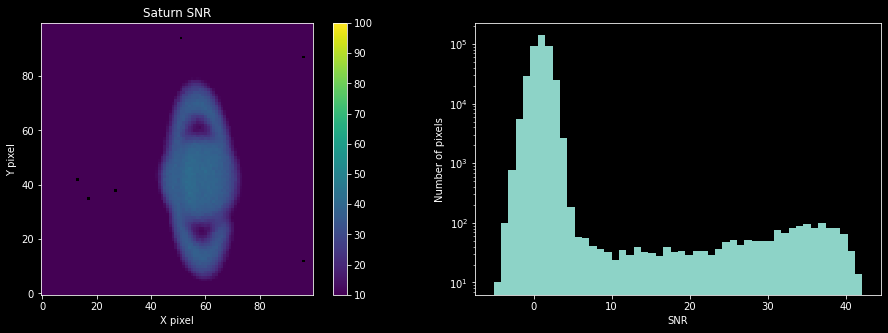

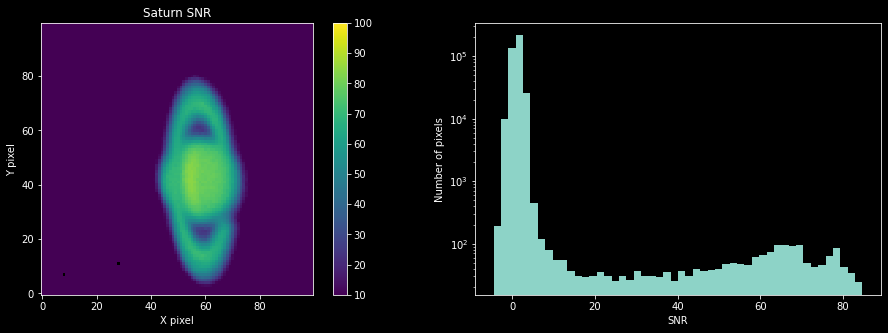

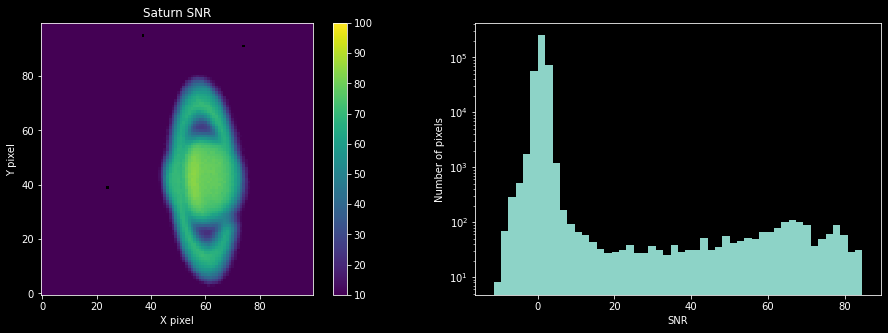

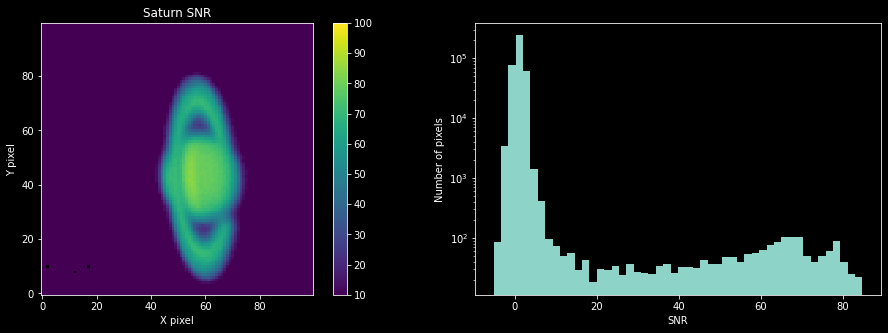

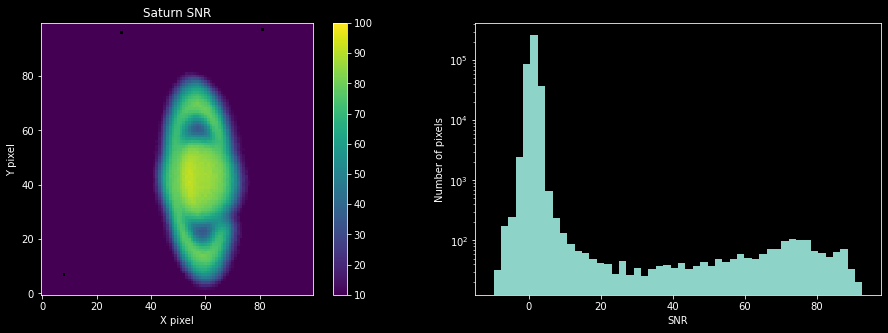

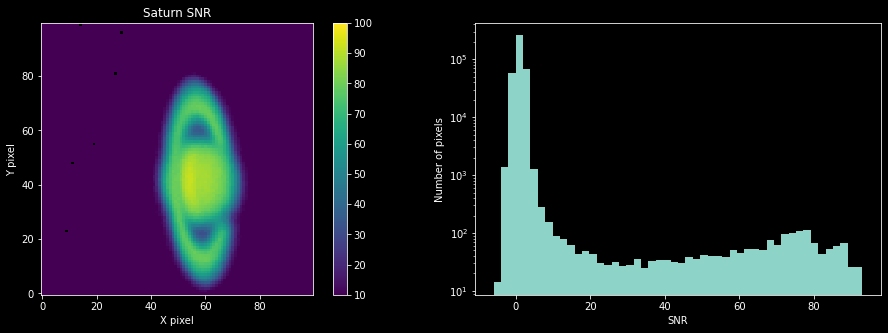

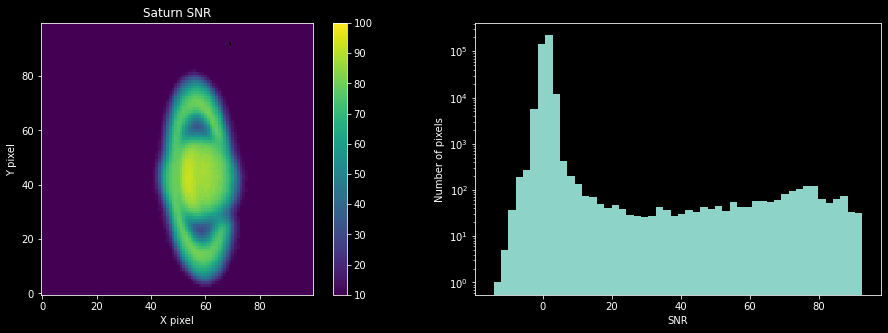

In [15]:
saturn_darksub = []
saturn_darksub_uncertainty = []
saturn_darksub_flattened = []
saturn_darksub_flattened_uncertainty = []
num = 0

for i in range(len(Saturn_shift)):
    if(i%3 == 0):
        num = num + 1
        #changes the flat filter
    saturn_darksub.append(Saturn_shift[i] - average_40ms_dark)
    saturn_darksub_uncertainty.append((saturn_darksub[i] + readnoise**2 + uncertainty_on_40ms_mean_dark**2)**0.5)
    saturn_darksub_flattened.append( saturn_darksub[i] / normalized_mean_flat[num])
    saturn_darksub_flattened_uncertainty.append(((saturn_darksub_uncertainty[i]**2 / saturn_darksub[i]**2 +normalized_flat_uncertainty[0]**2 / normalized_mean_flat[num]**2) * saturn_darksub_flattened[i]**2)**0.5)  
    SNR = saturn_darksub_flattened[i] / saturn_darksub_flattened_uncertainty[i]
    pl.figure(figsize=(16,5))
    #SNR Images:
    image = pl.subplot(1,2,1).imshow(SNR[175:275,350:450], origin='lower', interpolation='none', vmin=10, vmax=100)
    _=pl.title("Saturn SNR")
    _=pl.xlabel("X pixel")
    _=pl.ylabel("Y pixel")
    pl.colorbar(image)
    #Histogram:
    _ = pl.subplot(1,2,2).hist(SNR.ravel(), bins=50, log=True)
    _ = pl.xlabel("SNR")
    _ = pl.ylabel("Number of pixels")


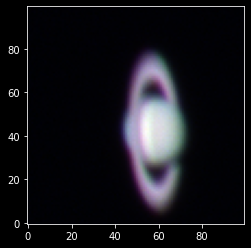

In [16]:
timeseries_sat_B = np.array([saturn_darksub_flattened[0],
                             saturn_darksub_flattened[1],
                             saturn_darksub_flattened[2]])
timeseries_sat_V = np.array([saturn_darksub_flattened[3],
                             saturn_darksub_flattened[4],
                             saturn_darksub_flattened[5]])
timeseries_sat_I = np.array([saturn_darksub_flattened[6],
                             saturn_darksub_flattened[7],
                             saturn_darksub_flattened[8]])

timeseries_sat = [timeseries_sat_B, timeseries_sat_V, timeseries_sat_I]

Bband_sat_median = np.median(timeseries_sat_B, axis = 0)
Vband_sat_median = np.median(timeseries_sat_V, axis = 0)
Iband_sat_median = np.median(timeseries_sat_I, axis = 0)

bslc = slice(175,275), slice(350,450)
vslc = slice(175,275), slice(350,450)
Islc = slice(175,275), slice(350,450)

minimum = 0
maximum = 100

norm_B = visualization.simple_norm(Bband_sat_median[bslc], 
                                   stretch = 'linear', 
                                   min_percent = minimum, 
                                   max_percent = maximum)

norm_V = visualization.simple_norm(Vband_sat_median[vslc], 
                                   stretch = 'linear', 
                                   min_percent = minimum, 
                                   max_percent = maximum)

norm_I = visualization.simple_norm(Iband_sat_median[Islc], 
                                   stretch = 'linear', 
                                   min_percent = minimum, 
                                   max_percent = maximum)

saturn_color = np.array([norm_I(Iband_sat_median),
                         norm_V(Vband_sat_median),
                         norm_B(Bband_sat_median)])


saturn_color=saturn_color.T.swapaxes(0,1)
saturn_color[:,:,0] = np.roll(saturn_color[:,:,0], 0, axis=0)
saturn_color[:,:,0] = np.roll(saturn_color[:,:,0], 0, axis=1)
bslc3d = (bslc[0], bslc[1], slice(None))

pl.imshow(saturn_color[bslc3d])


Photon Noise:

In [17]:
photon_noise_flat = []
total_noise_flat = []
average_flat_uncertainty = []
norm_flat_uncertainty = []
for i in range(3):
    photon_noise_flat.append(timeseries_sat[i]**0.5)
    total_noise_flat.append((photon_noise_flat[i]**2 + 
                        uncertainty_on_40ms_mean_dark**2 +
                        readnoise**2)**0.5)
    average_flat_uncertainty.append(total_noise_flat[i] / np.sqrt(len(darks_40ms_filelist)))
    norm_flat_uncertainty.append(average_flat_uncertainty[i] / bias_subtracted_flat[i].mean())




<ipython-input-17-21e45cf6725f>:6: RuntimeWarning: invalid value encountered in sqrt
  photon_noise_flat.append(timeseries_sat[i]**0.5)


In [18]:
photon_noise_estimate_sat = []
total_noise_estimate_sat = []
total_flat_noise_estimate_sat = []
final_mean_sat_noise = []

for i in range(3):
    photon_noise_estimate_sat.append(timeseries_sat[i]**0.5)
    photon_noise_estimate_sat[i][np.isnan(photon_noise_estimate_sat[i])] = 0
    total_noise_estimate_sat.append((photon_noise_estimate_sat[i]**2 + 
                                      uncertainty_on_40ms_mean_dark**2 +
                                      readnoise**2)**0.5)

    total_flat_noise_estimate_sat.append((((
        total_noise_estimate_sat[i]**2 /
        timeseries_sat[i]**2)
        + (norm_flat_uncertainty[i]**2 / normed_flat[i]**2)) * 
        timeseries_sat[i]**2)**0.5)
    final_mean_sat_noise.append(((
        total_flat_noise_estimate_sat[i]**2).sum(axis=0) /
        total_flat_noise_estimate_sat[i].shape[0]**2)**0.5)




<ipython-input-18-2c407c6c9a5f>:7: RuntimeWarning: invalid value encountered in sqrt
  photon_noise_estimate_sat.append(timeseries_sat[i]**0.5)
<ipython-input-18-2c407c6c9a5f>:14: RuntimeWarning: divide by zero encountered in true_divide
  total_noise_estimate_sat[i]**2 /
<ipython-input-18-2c407c6c9a5f>:13: RuntimeWarning: invalid value encountered in multiply
  total_flat_noise_estimate_sat.append((((


Photon Counts Saturn:

In [19]:
total_counts_sat_B = Bband_sat_median[bslc].sum()
total_counts_sat_V = Vband_sat_median[vslc].sum()
total_counts_sat_I = Iband_sat_median[Islc].sum()

print(f"Photon Counts: B={total_counts_sat_B:0.3g} photons, V={total_counts_sat_V:0.3g} photons, I={total_counts_sat_I:0.3g} photons,")
      
rate_B_sat = total_counts_sat_B / 0.04
rate_V_sat = total_counts_sat_V / 0.04
rate_I_sat = total_counts_sat_I / 0.04

print(f"Photon Rates: B={rate_B_sat:0.3g} ph/s, V={rate_V_sat:0.3g} ph/s, I={rate_I_sat:0.3g} ph/s,")


Photon Counts: B=2.14e+06 photons, V=7.32e+06 photons, I=9.44e+06 photons,
Photon Rates: B=5.35e+07 ph/s, V=1.83e+08 ph/s, I=2.36e+08 ph/s,


Photon Uncertainties:

In [20]:
uncertainty_cts_B_sat = np.nansum(final_mean_sat_noise[0][bslc]**2)**0.5
uncertainty_cts_V_sat = np.nansum(final_mean_sat_noise[1][vslc]**2)**0.5
uncertainty_cts_I_sat = np.nansum(final_mean_sat_noise[2][Islc]**2)**0.5

uncertainty_rate_B_sat = uncertainty_cts_B_sat / 0.04
uncertainty_rate_V_sat = uncertainty_cts_V_sat / 0.04
uncertainty_rate_I_sat = uncertainty_cts_I_sat / 0.04

print(f"Saturn Flux I Band ={rate_I_sat:12.3g} +/- {uncertainty_rate_I_sat:12.3g} ph/s ( SNR ={rate_I_sat/uncertainty_rate_I_sat:10.3g})")
print(f"Saturn Flux V Band ={rate_V_sat:12.3g} +/- {uncertainty_rate_V_sat:12.3g} ph/s ( SNR ={rate_V_sat/uncertainty_rate_V_sat:10.3g})")
print(f"Saturn Flux B Band ={rate_B_sat:12.3g} +/- {uncertainty_rate_B_sat:12.3g} ph/s ( SNR ={rate_B_sat/uncertainty_rate_B_sat:10.3g})")



Saturn Flux I Band =    2.36e+08 +/-     4.98e+04 ph/s ( SNR =  4.75e+03)
Saturn Flux V Band =    1.83e+08 +/-     4.47e+04 ph/s ( SNR =  4.09e+03)
Saturn Flux B Band =    5.35e+07 +/-     2.93e+04 ph/s ( SNR =  1.83e+03)


## Jupiter

In [21]:
JupiterFilelist = ['Jupiter_B_100ms002.FIT', 'Jupiter_B_100ms003.FIT',
                 'Jupiter_V_100ms001.FIT', 'Jupiter_V_100ms002.FIT', 'Jupiter_V_100ms003.FIT',
                 'Jupiter_I_100ms001.FIT', 'Jupiter_I_100ms002.FIT', 'Jupiter_I_100ms003.FIT']

JupiterCenters_X = [440.0, 440.0, 419.2, 420.9, 421.5, 433.3, 433.6, 433.6]
JupiterCenters_Y = [265.7, 266.1, 260.0, 261.1, 262.1, 262.1, 262.1, 263.1] 

#Making 'Jupiter_B_100ms001.FIT' the reference frame.
refx, refy = 440.0, 266.7 
Jupiter_shift = [fits.getdata('Jupiter_B_100ms001.FIT')*fits.getheader('Jupiter_B_100ms001.FIT')[ 'EGAIN']]

for i in range(len(JupiterFilelist)):
    im = fits.getdata(JupiterFilelist[i])*fits.getheader(JupiterFilelist[i])[ 'EGAIN']
    dx = refx - JupiterCenters_X[i]
    dy = refy - JupiterCenters_Y[i]
    dx, dy = round(dx), round(dy)    
    im_shift = np.roll(im, dy, axis=0)
    im_shift = np.roll(im_shift, dx, axis=1)
    Jupiter_shift.append(im_shift)
    #Saving the shifted images
    header = fits.getheader(JupiterFilelist[i])
    fh = fits.PrimaryHDU(data=im_shift, header=header) 
    fh.writeto('shifted_' + JupiterFilelist[i], overwrite=True)

header = fits.getheader('Jupiter_B_100ms001.FIT')
fh = fits.PrimaryHDU(data=Jupiter_shift[0], header=header) 
fh.writeto('shifted_' + 'Jupiter_B_100ms001.FIT', overwrite=True)

<ipython-input-22-83285961a782>:14: RuntimeWarning: divide by zero encountered in true_divide
  jupiter_darksub_flattened_uncertainty.append(((jupiter_darksub_uncertainty[i]**2 / jupiter_darksub[i]**2 +normalized_flat_uncertainty[0]**2 / normalized_mean_flat[num]**2) * jupiter_darksub_flattened[i]**2)**0.5)
<ipython-input-22-83285961a782>:14: RuntimeWarning: invalid value encountered in multiply
  jupiter_darksub_flattened_uncertainty.append(((jupiter_darksub_uncertainty[i]**2 / jupiter_darksub[i]**2 +normalized_flat_uncertainty[0]**2 / normalized_mean_flat[num]**2) * jupiter_darksub_flattened[i]**2)**0.5)
<ipython-input-22-83285961a782>:12: RuntimeWarning: invalid value encountered in sqrt
  jupiter_darksub_uncertainty.append((jupiter_darksub[i] + readnoise**2 + uncertainty_on_40ms_mean_dark**2)**0.5)


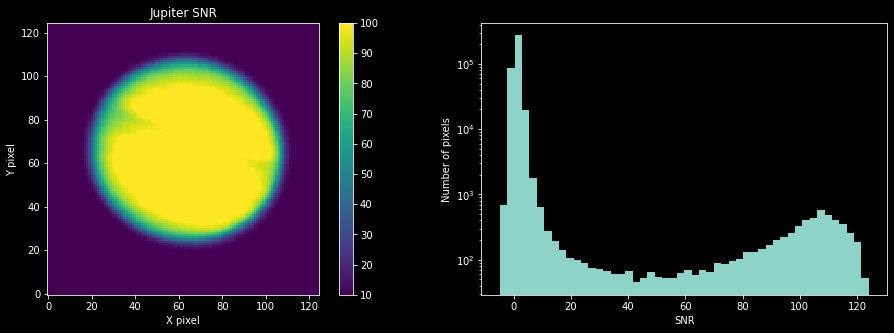

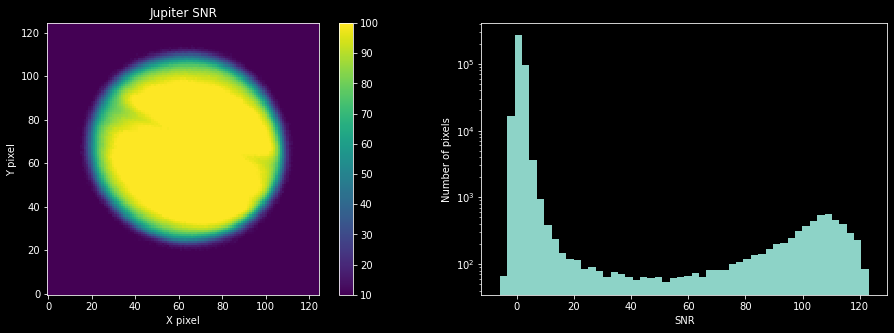

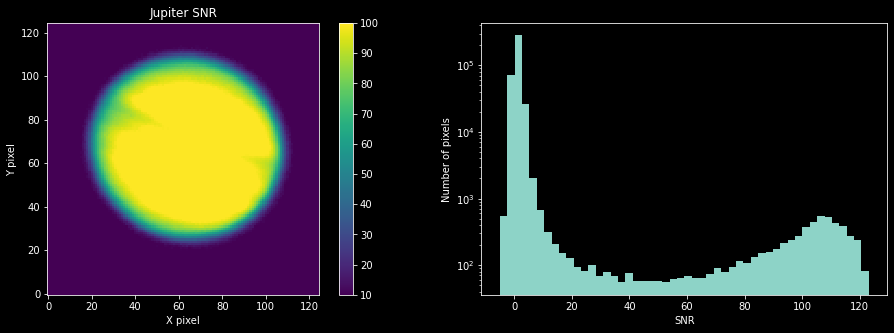

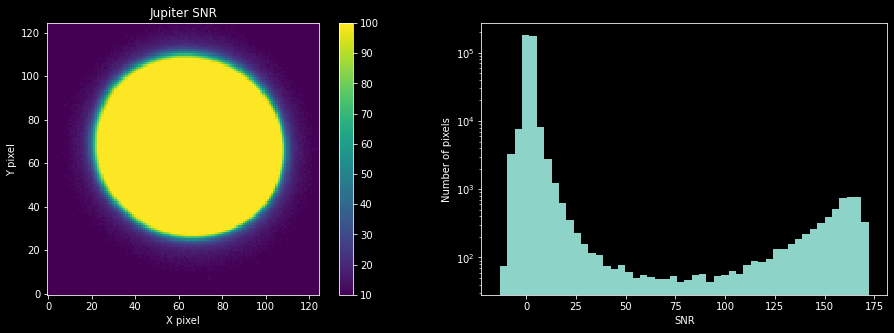

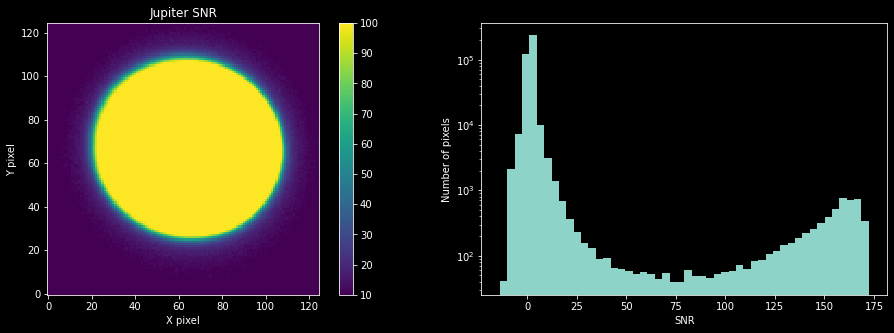

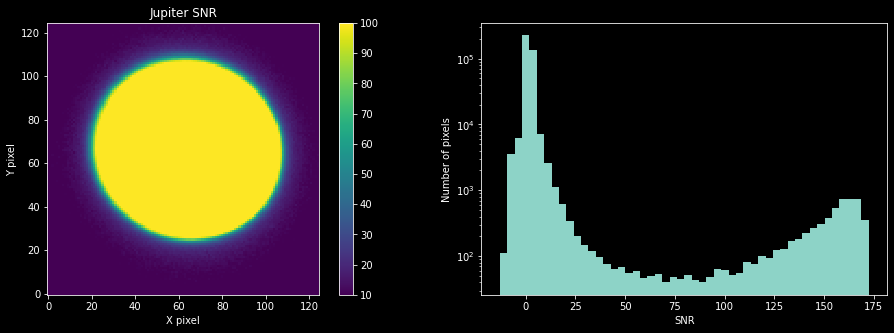

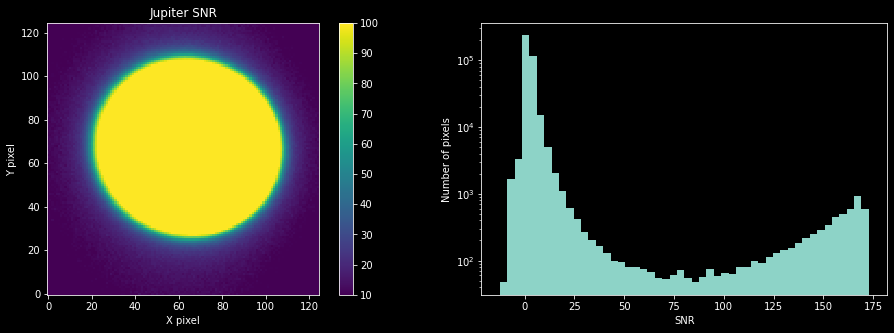

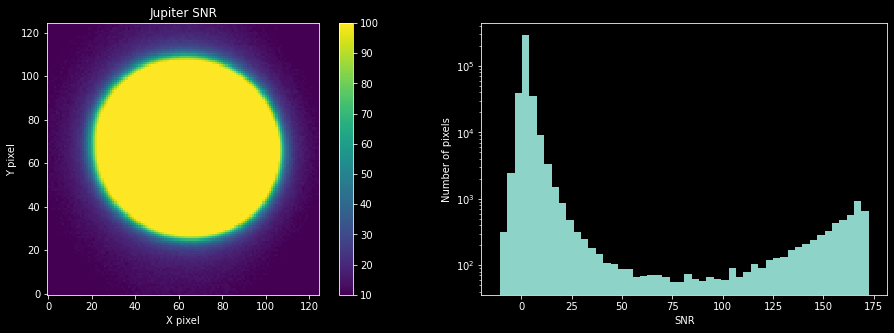

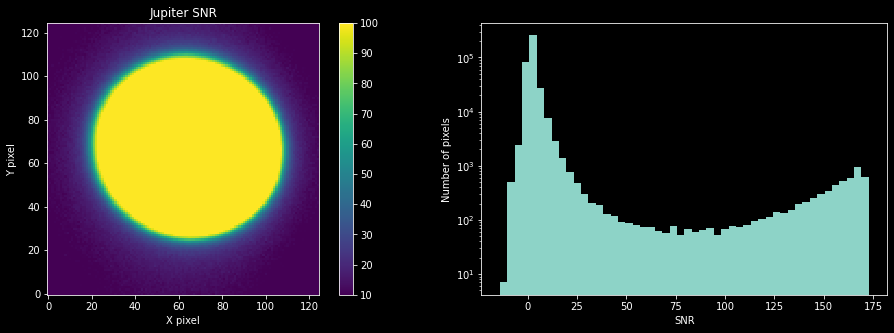

In [22]:
jupiter_darksub = []
jupiter_darksub_uncertainty = []
jupiter_darksub_flattened = []
jupiter_darksub_flattened_uncertainty = []
num = 0

for i in range(len(Jupiter_shift)):
    if(i%3 == 0):
        num = num + 1
        #changes the flat filter
    jupiter_darksub.append(Jupiter_shift[i] - average_40ms_dark)
    jupiter_darksub_uncertainty.append((jupiter_darksub[i] + readnoise**2 + uncertainty_on_40ms_mean_dark**2)**0.5)
    jupiter_darksub_flattened.append( jupiter_darksub[i] / normalized_mean_flat[num])
    jupiter_darksub_flattened_uncertainty.append(((jupiter_darksub_uncertainty[i]**2 / jupiter_darksub[i]**2 +normalized_flat_uncertainty[0]**2 / normalized_mean_flat[num]**2) * jupiter_darksub_flattened[i]**2)**0.5)  
    SNR = jupiter_darksub_flattened[i] / jupiter_darksub_flattened_uncertainty[i]
    pl.figure(figsize=(16,5))
    #SNR Images:
    image = pl.subplot(1,2,1).imshow(SNR[200:325,375:500], origin='lower', interpolation='none', vmin=10, vmax=100)
    _=pl.title("Jupiter SNR")
    _=pl.xlabel("X pixel")
    _=pl.ylabel("Y pixel")
    pl.colorbar(image)
    #Histogram:
    _ = pl.subplot(1,2,2).hist(SNR.ravel(), bins=50, log=True)
    _ = pl.xlabel("SNR")
    _ = pl.ylabel("Number of pixels")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


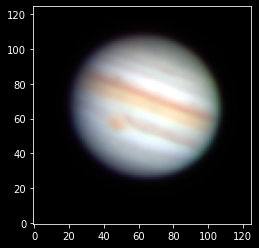

In [26]:
timeseries_jup_B = np.array([jupiter_darksub_flattened[0],
                             jupiter_darksub_flattened[1],
                             jupiter_darksub_flattened[2]])
timeseries_jup_V = np.array([jupiter_darksub_flattened[3],
                             jupiter_darksub_flattened[4],
                             jupiter_darksub_flattened[5]])
timeseries_jup_I = np.array([jupiter_darksub_flattened[6],
                             jupiter_darksub_flattened[7],
                             jupiter_darksub_flattened[8]])

timeseries_jup = [timeseries_jup_B,
                 timeseries_jup_V,
                 timeseries_jup_I]

Bband_jup_median = np.median(timeseries_jup_B, axis = 0)
Vband_jup_median = np.median(timeseries_jup_V, axis = 0)
Iband_jup_median = np.median(timeseries_jup_I, axis = 0)

bslc_jup = slice(200,325), slice(375,500)
vslc_jup = slice(200,325), slice(375,500)
Islc_jup = slice(200,325), slice(375,500)

minimum = 1
maximum = 99

norm_B_jup = visualization.simple_norm(Bband_jup_median[bslc_jup], 
                                   stretch = 'linear', 
                                   min_percent = minimum, 
                                   max_percent = maximum)

norm_V_jup = visualization.simple_norm(Vband_jup_median[vslc_jup], 
                                   stretch = 'linear', 
                                   min_percent = minimum, 
                                   max_percent = maximum)

norm_I_jup = visualization.simple_norm(Iband_jup_median[Islc_jup], 
                                   stretch = 'linear', 
                                   min_percent = minimum, 
                                   max_percent = maximum)

jupiter_color = np.array([norm_I_jup(Iband_jup_median),
                         norm_V_jup(Vband_jup_median),
                         norm_B_jup(Bband_jup_median)])


jupiter_color=jupiter_color.T.swapaxes(0,1)
jupiter_color[:,:,0] = np.roll(jupiter_color[:,:,0], 0, axis=0)
jupiter_color[:,:,0] = np.roll(jupiter_color[:,:,0], 0, axis=1)
bslc3d_jup = (bslc_jup[0], bslc_jup[1], slice(None))

pl.imshow(jupiter_color[bslc3d_jup])
#pl.imshow(jupiter_color)


In [32]:
photon_noise_estimate_jup = []
total_noise_estimate_jup = []
total_flat_noise_estimate_jup = []
final_mean_jup_noise = []

for i in range(3):
    photon_noise_estimate_jup.append(timeseries_jup[i]**0.5)
    photon_noise_estimate_jup[i][np.isnan(photon_noise_estimate_jup[i])] = 0
    total_noise_estimate_jup.append((photon_noise_estimate_jup[i]**2 + 
                                      uncertainty_on_100ms_mean_dark**2 +
                                      readnoise**2)**0.5)

    total_flat_noise_estimate_jup.append((((
        total_noise_estimate_jup[i]**2 /
        timeseries_jup[i]**2)
        + (norm_flat_uncertainty[i]**2 / normed_flat[i]**2)) * 
        timeseries_jup[i]**2)**0.5)
    final_mean_jup_noise.append(((
        total_flat_noise_estimate_jup[i]**2).sum(axis=0) /
        total_flat_noise_estimate_jup[i].shape[0]**2)**0.5)




<ipython-input-32-4b62ee72fead>:7: RuntimeWarning: invalid value encountered in sqrt
  photon_noise_estimate_jup.append(timeseries_jup[i]**0.5)
<ipython-input-32-4b62ee72fead>:14: RuntimeWarning: divide by zero encountered in true_divide
  total_noise_estimate_jup[i]**2 /
<ipython-input-32-4b62ee72fead>:13: RuntimeWarning: invalid value encountered in multiply
  total_flat_noise_estimate_jup.append((((


In [33]:
total_counts_jup_B = Bband_jup_median[bslc_jup].sum()
total_counts_jup_V = Vband_jup_median[vslc_jup].sum()
total_counts_jup_I = Iband_jup_median[Islc_jup].sum()

print(f"Photon Counts: B={total_counts_jup_B:0.3g} photons, V={total_counts_jup_V:0.3g} photons, I={total_counts_jup_I:0.3g} photons,")
      
rate_B_jup = total_counts_jup_B / 0.04
rate_V_jup = total_counts_jup_V / 0.04
rate_I_jup = total_counts_jup_I / 0.04

print(f"Photon Rates: B={rate_B_jup:0.3g} ph/s, V={rate_V_jup:0.3g} ph/s, I={rate_I_jup:0.3g} ph/s,")


Photon Counts: B=7.57e+07 photons, V=2.46e+08 photons, I=2.58e+08 photons,
Photon Rates: B=1.89e+09 ph/s, V=6.15e+09 ph/s, I=6.46e+09 ph/s,


In [34]:
uncertainty_cts_B_jup = np.nansum(final_mean_jup_noise[0][bslc_jup]**2)**0.5
uncertainty_cts_V_jup = np.nansum(final_mean_jup_noise[1][vslc_jup]**2)**0.5
uncertainty_cts_I_jup = np.nansum(final_mean_jup_noise[2][Islc_jup]**2)**0.5

uncertainty_rate_B_jup = uncertainty_cts_B_jup / 0.04
uncertainty_rate_V_jup = uncertainty_cts_V_jup / 0.04
uncertainty_rate_I_jup = uncertainty_cts_I_jup / 0.04

print(f"Saturn Flux I Band ={rate_I_jup:12.3g} +/- {uncertainty_rate_I_jup:12.3g} ph/s ( SNR ={rate_I_jup/uncertainty_rate_I_jup:10.3g})")
print(f"Saturn Flux V Band ={rate_V_jup:12.3g} +/- {uncertainty_rate_V_jup:12.3g} ph/s ( SNR ={rate_V_jup/uncertainty_rate_V_jup:10.3g})")
print(f"Saturn Flux B Band ={rate_B_jup:12.3g} +/- {uncertainty_rate_B_jup:12.3g} ph/s ( SNR ={rate_B_jup/uncertainty_rate_B_jup:10.3g})")



Saturn Flux I Band =    6.46e+09 +/-      2.1e+05 ph/s ( SNR =  3.07e+04)
Saturn Flux V Band =    6.15e+09 +/-     1.95e+05 ph/s ( SNR =  3.15e+04)
Saturn Flux B Band =    1.89e+09 +/-     1.05e+05 ph/s ( SNR =   1.8e+04)
